<a href="https://colab.research.google.com/github/dorzv/ComputerVision/blob/master/self_supervised_learning/SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightning torchmetrics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.4 MB/s eta 0:00:00


In [2]:
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import OneCycleLR

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint

import torchvision
import torchvision.transforms.v2 as transforms
import torchvision.models as models
from torchvision.datasets import STL10

from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split

import numpy as np

In [ ]:
L.seed_everything(0)

Seed set to 0


0

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_worker = os.cpu_count()
print(f'{device=}')
print(f'{num_worker=}')

device='cuda'
num_worker=24


## Dataset

In [ ]:
DATASET_PATH = 'STL10'

In [ ]:
class AugmentationViews:
  """
  Create multiple augmentations for an image
  """
  def __init__(self, transform, num_views):
    self.transform = transform
    self.num_views = num_views

  def __call__(self, image):
    return [self.transform(image) for _ in range(self.num_views)]

In [ ]:
base_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=AugmentationViews(base_transform, num_views=2))

train_data = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=AugmentationViews(base_transform, num_views=2)
)

Files already downloaded and verified
Files already downloaded and verified


Visualize the dataset

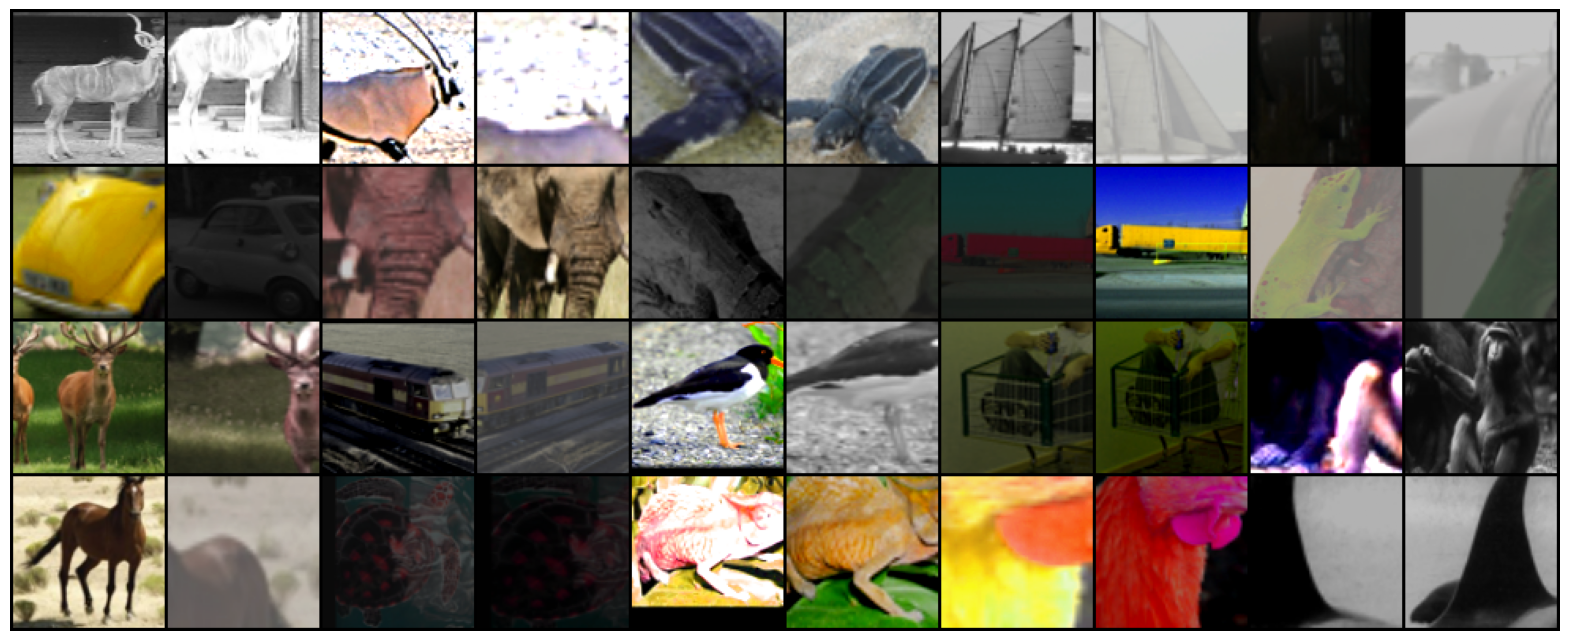

In [ ]:
NUM_IMAGES = 20
images = torch.stack([image for ii in range(NUM_IMAGES)
                    for image in unlabeled_data[ii][0]],
                   dim=0)
images_grid = torchvision.utils.make_grid(images, nrow=10, normalize=True)
images_grid = images_grid.permute(1, 2, 0)

plt.figure(figsize=(20, 10))
plt.imshow(images_grid)
plt.axis("off")
plt.show()


## Models and Loss


In [ ]:
class NTXentLoss(nn.Module):

    def __init__(self, batch_size, temperature, device='cuda'):
      super().__init__()
      self.batch_size = batch_size
      self.device = device
      self.temperature = temperature
      self.similarity_function = nn.CosineSimilarity(dim=-1)
      self.negative_pairs_mask = self.get_negative_mask()
      self.criterion = nn.CrossEntropyLoss(reduction="sum").to(device)

    def calculate_similarity_matrix(self, x, y):
      """
      Calculate the similary between each vector in the first
      argument with each vector in the second one, to get a matrix
      of similarity scores between all the vectors in the two arguments
      """
      return self.similarity_function(x.unsqueeze(1), y.unsqueeze(0))

    def get_negative_mask(self):
      """
      Create a mask with True for negative elements, i.e.
      pairs from views that don't come from the same
      original image
      """
      mat_1 = np.eye(2 * self.batch_size)
      mat_2 = np.eye(2 * self.batch_size, k=-self.batch_size)
      mat_3 = np.eye(2 * self.batch_size, k=self.batch_size)
      mask = torch.from_numpy((mat_1 + mat_2 + mat_3))
      mask = (1 - mask).type(torch.bool)
      return mask

    def forward(self, zis, zjs):
      """
      Args:
      zis (torch.Tensor): projections of the first view of the images
      zis (torch.Tensor): projections of the second view of the images
      """
      projections = torch.cat([zjs, zis], dim=0)

      similarity_matrix = self.calculate_similarity_matrix(projections, projections)  #[2N, 2N]
      # The positive pairs are on the batch_size-th diagonals of the similarity matrix
      positive_pairs_1 = torch.diag(similarity_matrix, self.batch_size)  # [N]
      positive_pairs_2 = torch.diag(similarity_matrix, -self.batch_size)  # [N]
      positives_pairs = torch.cat([positive_pairs_1, positive_pairs_2]).view(2 * self.batch_size, 1)  # [2N, 1]

      negatives_pairs = similarity_matrix[self.negative_pairs_mask].view(2 * self.batch_size, -1)  # [2N, 2N-2]

      logits = torch.cat((positives_pairs, negatives_pairs), dim=1).to(self.device)  # [2N, 2N-1]
      logits /= self.temperature

      labels = torch.zeros(2 * self.batch_size).long().to(self.device)
      loss = self.criterion(logits, labels)

      return loss / (2 * self.batch_size)

## SimCLR Training

In [ ]:
class ResNetSimCLR(L.LightningModule):
  def __init__(self, backbone, output_dim, batch_size, freeze=True, device='cuda'):
    super().__init__()
    self.save_hyperparameters()  # save the parameters of model into check points
    self.represntation_num_of_features = backbone.fc.in_features
    self.features_extractor = nn.Sequential(*list(backbone.children())[:-1])  #  ResNet without the classifier

    if freeze:
      # freeze all parameters of the features extractor except to the 2 last blocks
      num_blocks = len(list(self.features_extractor.children()))
      for index_block, block in enumerate(list(self.features_extractor.children()), 1):
        if index_block <= num_blocks-2:
          for param in block.parameters():
            param.requires_grad = False

    self.mlp = nn.Sequential(
        nn.Linear(self.represntation_num_of_features, 2 * self.represntation_num_of_features),
        nn.BatchNorm1d(2 * self.represntation_num_of_features),
        nn.SELU(inplace=True),
        nn.Linear(2*self.represntation_num_of_features, self.represntation_num_of_features),
        nn.BatchNorm1d(self.represntation_num_of_features),
        nn.SELU(inplace=True),
        nn.Linear(self.represntation_num_of_features, output_dim)
    )

    self.loss = NTXentLoss(batch_size, 0.05, device)

  def forward(self, x):
    h = self.features_extractor(x)
    h = h.squeeze()
    z = self.mlp(h)
    return h, z

  def training_step(self, batch, batch_idx):
    x, _ = batch
    xis, xjs = x  # two augmented views for each image
    _, zis = self(xis)
    _, zjs = self(xjs)

    loss = self.loss(zis, zjs)
    return loss

  def validation_step(self, batch, batch_idx):
    x, _ = batch
    xis, xjs = x  # two augmented views for each image
    _, zis = self(xis)
    _, zjs = self(xjs)

    loss = self.loss(zis, zjs)
    self.log('val_loss', loss)  # log to tensorboard
    return loss

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=1e-4)
    scheduler = OneCycleLR(optimizer, anneal_strategy='cos', max_lr=0.1, total_steps=1500)
    return [optimizer], [scheduler]


In [ ]:
batch_size = 128
train_dataloader = DataLoader(unlabeled_data, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=num_worker)
val_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False, drop_last=True, pin_memory=True, num_workers=num_worker)

In [ ]:
resnet50 = models.resnet50(weights=None)
simclr = ResNetSimCLR(resnet50, 128, batch_size, device=device, freeze=False)

# Pytorch Lightning Trainer
checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_last=True)
trainer = L.Trainer(accelerator="auto", max_epochs=100, callbacks=checkpoint_callback)
trainer.fit(model=simclr, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

## Clasification

In [ ]:
train_data = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=transforms.ToTensor())

test_data = STL10(
    root=DATASET_PATH,
    split="test",
    download=True,
    transform=transforms.ToTensor()
)

batch_size = 128
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=num_worker)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=num_worker)

In [ ]:
class Classifier(L.LightningModule):
    def __init__(self, features_extractor, representation_dim, num_classes):
        super().__init__()
        self.save_hyperparameters()
        self.features_extractor = features_extractor
        self.classifier = nn.Sequential(
            nn.Linear(representation_dim, 2 * representation_dim),
            nn.BatchNorm1d(2 * representation_dim),
            nn.SELU(inplace=True),
            nn.Linear(2 * representation_dim, num_classes)
          )
        self.accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, x):
        x = self.features_extractor(x)
        x = x.squeeze()
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_predicted = self(x)
        loss = F.cross_entropy(y_predicted, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_predicted = self(x)
        loss = F.cross_entropy(y_predicted, y)
        self.accuracy_metric.update(y_predicted, y)
        self.log('accuracy', self.accuracy_metric, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=3e-4)
        return optimizer


In [ ]:
simclr = ResNetSimCLR.load_from_checkpoint(checkpoint_callback.best_model_path)
features_extractor = simclr.features_extractor
representation_dim = simclr.represntation_num_of_features
classifier = Classifier(features_extractor=features_extractor, representation_dim=representation_dim, num_classes=10)

# Pytorch Lightning Trainer
checkpoint_callback_classifier = ModelCheckpoint(dirpath='Classifier', monitor='accuracy', mode='max', save_last=True)
trainer = L.Trainer(accelerator="auto", max_epochs=200, callbacks=checkpoint_callback_classifier)
trainer.fit(model=classifier, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

In [ ]:
print(f'Best accuracy is {checkpoint_callback_classifier.best_model_score}')

Best accuracy is 0.7772499918937683


### Subset
Use only 10% of the labels

In [ ]:
labels = [x for _, x in train_data]
indexes = list(range(len(labels)))

indexes_subset, *_ = train_test_split(indexes, labels, train_size=0.1, shuffle=True, stratify=labels)
train_data_subset = Subset(train_data, indexes_subset)
train_dataloader_subset = DataLoader(train_data_subset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=num_worker)

In [ ]:
simclr = ResNetSimCLR.load_from_checkpoint(checkpoint_callback.best_model_path)
features_extractor = simclr.features_extractor
representation_dim = simclr.represntation_num_of_features
classifier_subset = Classifier(features_extractor=features_extractor, representation_dim=representation_dim, num_classes=10)

# Pytorch Lightning Trainer
checkpoint_callback_classifier_subset = ModelCheckpoint(dirpath='ClassifierSubset',monitor='accuracy', mode='max', save_last=True)
trainer = L.Trainer(accelerator="auto", max_epochs=200, callbacks=checkpoint_callback_classifier_subset)
trainer.fit(model=classifier_subset, train_dataloaders=train_dataloader_subset, val_dataloaders=test_dataloader)

In [ ]:
print(f'Best accuracy is {checkpoint_callback_classifier_subset.best_model_score}')

Best accuracy is 0.6567500233650208


## Supervised Only
Train in similar way but only with labeled data (5000 images)

In [ ]:
class SupervisedClassifier(L.LightningModule):
    def __init__(self, resnet, num_classes, freeze=True):
        super().__init__()
        self.features_extractor = nn.Sequential(*list(resnet.children())[:-1])  #  ResNet without the classifier
        self.num_classes = num_classes
        self.classifier_head_input_dim = resnet.fc.in_features

        if freeze:
            # freeze all parameters of the features extractor except to the 2 last blocks
            num_blocks = len(list(self.features_extractor.children()))
            for index_block, block in enumerate(list(self.features_extractor.children()), 1):
                if index_block <= num_blocks-2:
                  for param in block.parameters():
                    param.requires_grad = False

        self.classifier_head = nn.Sequential(
            nn.Linear(self.classifier_head_input_dim, 2 * self.classifier_head_input_dim),
            nn.BatchNorm1d(2 * self.classifier_head_input_dim),
            nn.SELU(inplace=True),
            nn.Linear(2 * self.classifier_head_input_dim, num_classes)
          )
        self.accuracy_metric = Accuracy(task='multiclass', num_classes=num_classes)

    def forward(self, x):
        x = self.features_extractor(x)
        x = x.squeeze()
        x = self.classifier_head(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_predicted = self(x)
        loss = F.cross_entropy(y_predicted, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_predicted = self(x)
        loss = F.cross_entropy(y_predicted, y)
        self.accuracy_metric.update(y_predicted, y)
        self.log('accuracy', self.accuracy_metric, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=3e-4)
        return optimizer


In [ ]:
resnet50 = models.resnet50(weights=None)
supervised_classifier = SupervisedClassifier(resnet50, 10, freeze=False)

# Pytorch Lightning Trainer
checkpoint_callback_supervised_classifier = ModelCheckpoint(dirpath='SupervisedClassifier',monitor='accuracy', mode='max', save_last=True)
trainer = L.Trainer(accelerator="auto", max_epochs=200, callbacks=checkpoint_callback_supervised_classifier)
trainer.fit(model=supervised_classifier, train_dataloaders=train_dataloader, val_dataloaders=test_dataloader)

In [ ]:
print(f'Best accuracy is {checkpoint_callback_supervised_classifier.best_model_score}')

Best accuracy is 0.5256249904632568


### Supervised Subset
Use only 10% of the labels

In [ ]:
resnet50 = models.resnet50(weights=None)
supervised_classifier_subset = SupervisedClassifier(resnet50, 10, freeze=False)

# Pytorch Lightning Trainer
checkpoint_callback_supervised_classifier_subset = ModelCheckpoint(dirpath='SupervisedClassifierSubset',monitor='accuracy', mode='max', save_last=True)
trainer = L.Trainer(accelerator="auto", max_epochs=200, callbacks=checkpoint_callback_supervised_classifier_subset)
trainer.fit(model=supervised_classifier_subset, train_dataloaders=train_dataloader_subset, val_dataloaders=test_dataloader)

In [ ]:
print(f'Best accuracy is {checkpoint_callback_supervised_classifier_subset.best_model_score}')

Best accuracy is 0.30937498807907104
